In [1]:
%matplotlib inline
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from itertools import islice
from torch.utils.data import DataLoader,Dataset

In [2]:
CUDA_FLAG = torch.cuda.is_available()
print(CUDA_FLAG)

False


In [3]:
SEED = 1
torch.manual_seed(SEED)
if CUDA_FLAG:
    torch.cuda.manual_seed(SEED)

SEQ_LEN = 465
EMBEDDING_LEN = 120
NUM_TRAINING_PAIRS = 20 * 500
NUM_EPOCH = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 100

class Config():
    train_data_fp = './demo/pair_shuffle.fa'
    train_target_fp = './demo/dist_shuffle.txt'
    train_num_example = NUM_TRAINING_PAIRS
    train_batch_size = BATCH_SIZE
    num_epoch = NUM_EPOCH
    learning_rate =LEARNING_RATE

In [4]:
class MaxMinout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, embedding1, embedding2):
        shape = list(embedding1.size())
        flat1 = embedding1.view(1, -1)
        flat2 = embedding2.view(1, -1)
        combined = torch.cat((flat1, flat2), 0)
        maxout = combined.max(0)[0].view(*shape)
        # minout = combined.min(0)[0].view(*shape)
        minout = ((combined * -1).max(0)[0].view(*shape) * -1) # workaround for memory leak bug

        return maxout, minout

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxminout = MaxMinout()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
                
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
               
            nn.Conv1d(32, 48, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )
        max_pooling_len = SEQ_LEN 
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        self.fc = nn.Sequential(
            nn.Linear(int(48 * max_pooling_len), EMBEDDING_LEN),
        )

    def forward_one_side(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        embedding1 = self.forward_one_side(input1)
        embedding2 = self.forward_one_side(input2)
        maxout, minout = self.maxminout(embedding1, embedding2)
        return maxout, minout

In [5]:
def weight_func(dist):
    return 1.0
#     return 100.0 if dist < 0.2 else 1.0

class ContrastiveLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, maxout, minout, align_dist):
        weight = Variable(torch.FloatTensor([weight_func(x) for x in align_dist.data]), requires_grad=False)
        if CUDA_FLAG:
            weight = weight.cuda()
        loss_contrastive = torch.mean(torch.mul(weight, torch.pow(1 - minout.sum(1)/maxout.sum(1) - align_dist, 2)))

        return loss_contrastive

In [6]:
atcg_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

class SiameseNetworkDataset(Dataset):
    def __init__(self, data_fp, target_fp, N):
        self.data_fp = data_fp
        self.target_fp = target_fp
        self.N = N
        self.data_tensor = self.gen_data_tensor()
        self.target_tensor = self.gen_target_tensor()
        
    def __getitem__(self, index):
        return self.data_tensor[0][index], self.data_tensor[1][index], self.target_tensor[index]

    def __len__(self):
        return self.N
    
    def gen_data_tensor(self):
        seq1 = torch.zeros((self.N, 4, SEQ_LEN))
        seq2 = torch.zeros((self.N, 4, SEQ_LEN))
        cnt = 0
        with open(self.data_fp) as f:
            while True:
                next_n = list(islice(f, 4))
                if not next_n:
                    break
                if cnt >= self.N:
                    break
                read1 = next_n[1].strip()
                read2 = next_n[3].strip()
                for i, c in enumerate(read1):
                    seq1[cnt, atcg_map.get(c, 0), i] = 1.0
                for i, c in enumerate(read2):
                    seq2[cnt, atcg_map.get(c, 0), i] = 1.0
                cnt += 1
        return seq1, seq2

    def gen_target_tensor(self):
        target = torch.zeros(self.N)
        with open(self.target_fp) as f:
            for i, line in enumerate(f):
                if i >= self.N:
                    break
                pair_id, dist = line.strip().split()
                target[i] = float(dist)
        return target

In [7]:
net = SiameseNetwork()    
if CUDA_FLAG:
    net.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=Config.learning_rate, weight_decay=0)
print(net)

training_dataset = SiameseNetworkDataset(Config.train_data_fp, 
                                         Config.train_target_fp,
                                         Config.train_num_example)

training_loader = DataLoader(
    dataset=training_dataset,      
    batch_size=Config.train_batch_size,      
    shuffle=True,              
    num_workers=0,#4              
)

SiameseNetwork(
  (maxminout): MaxMinout()
  (cnn): Sequential(
    (0): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(32, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2784, out_features=120, bias=True)
  )
)


In [8]:
train_num_batch = int(np.ceil(Config.train_num_example / Config.train_batch_size))
train_batch_interval = Config.train_num_example // Config.train_batch_size // 10
train_loss_hist = []

for epoch in range(Config.num_epoch):
    print('===========>')
    train_running_loss = 0
    for batch_index, (train_seq1, train_seq2, train_target) in enumerate(training_loader):
        if CUDA_FLAG:
            train_seq1 = train_seq1.cuda()
            train_seq2 = train_seq2.cuda()
            train_target = train_target.cuda()
        train_seq1 = Variable(train_seq1)
        train_seq2 = Variable(train_seq2)
        train_target = Variable(train_target).float()
        train_output1, train_output2 = net(train_seq1, train_seq2)
        train_loss_contrastive = criterion(train_output1, train_output2, train_target)
        #train_running_loss += train_loss_contrastive.data[0]
        train_running_loss += train_loss_contrastive.item()
        
        if batch_index % train_batch_interval == train_batch_interval - 1:
            print('Epoch: {:d}/{:d}, Batch: {:d}/{:d}\n'
                  'Accumulated loss: {:.4e}'.format(
                  epoch + 1, Config.num_epoch, 
                  batch_index + 1, train_num_batch, 
                  train_running_loss / (batch_index + 1)))
            
        optimizer.zero_grad()
        train_loss_contrastive.backward()
        optimizer.step() 
    train_loss = train_running_loss / train_num_batch
    train_loss_hist.append(train_loss)
    print('Train loss: {:.4e}'.format(train_loss))

===========>
Epoch: 1/10, Batch: 10/100
Accumulated loss: 2.0194e-01
Epoch: 1/10, Batch: 20/100
Accumulated loss: 1.0501e-01
Epoch: 1/10, Batch: 30/100
Accumulated loss: 7.3640e-02
Epoch: 1/10, Batch: 40/100
Accumulated loss: 5.8141e-02
Epoch: 1/10, Batch: 50/100
Accumulated loss: 4.8754e-02
Epoch: 1/10, Batch: 60/100
Accumulated loss: 4.2427e-02
Epoch: 1/10, Batch: 70/100
Accumulated loss: 3.7931e-02
Epoch: 1/10, Batch: 80/100
Accumulated loss: 3.4387e-02
Epoch: 1/10, Batch: 90/100
Accumulated loss: 3.1600e-02
Epoch: 1/10, Batch: 100/100
Accumulated loss: 2.9252e-02
Train loss: 2.9252e-02
===========>
Epoch: 2/10, Batch: 10/100
Accumulated loss: 7.0238e-03
Epoch: 2/10, Batch: 20/100
Accumulated loss: 6.0767e-03
Epoch: 2/10, Batch: 30/100
Accumulated loss: 5.1556e-03
Epoch: 2/10, Batch: 40/100
Accumulated loss: 4.3754e-03
Epoch: 2/10, Batch: 50/100
Accumulated loss: 3.7455e-03
Epoch: 2/10, Batch: 60/100
Accumulated loss: 3.2981e-03
Epoch: 2/10, Batch: 70/100
Accumulated loss: 2.9486e-0

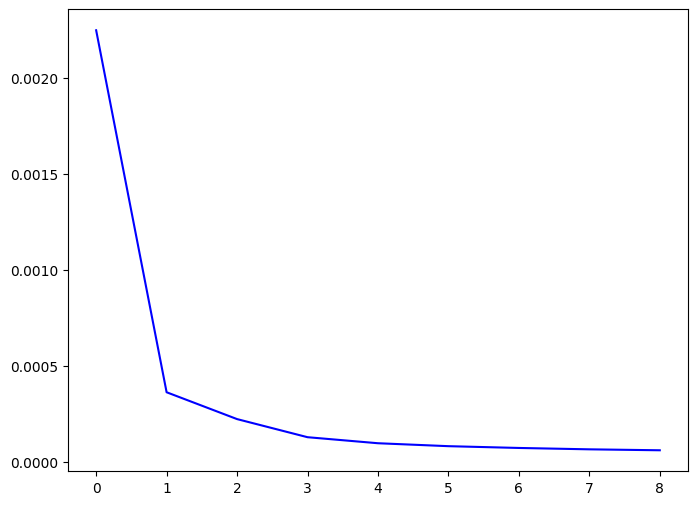

In [9]:
def plot_loss():
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_hist[1:], 'b')
plot_loss()

In [10]:
def jaccard_dist(embedding1, embedding2):
    return 1 - np.sum(np.minimum(embedding1, embedding2)) / np.sum(np.maximum(embedding1, embedding2)) 
    
def pair_dist(fp, N, embedding_fp, dist_fp):
    seq = torch.zeros((N, 4, SEQ_LEN))
    cnt = 0
    seq_ids = []
    with open(fp) as f:
        while True:
            next_n = list(islice(f, 2))
            if not next_n:
                break
            seq_id = next_n[0].strip()[1:]
            read = next_n[1].strip()
            seq_ids.append(seq_id)
            for i, c in enumerate(read):
                seq[cnt, atcg_map.get(c, 0), i] = 1.0
            cnt += 1
    embeddings = net.forward_one_side(Variable(seq)).data.numpy()
    embeddings.tofile(embedding_fp, sep=',', format='%.4e')
    with open(dist_fp, 'w') as fo:
        for i in range(N):
            for j in range(N):
                if i < j:
                    fo.write('{}-{}\t{:.4f}\n'.format(
                        seq_ids[i], seq_ids[j],
                        jaccard_dist(embeddings[i],
                                     embeddings[j])))

In [11]:
def my_plot(align_dist_df, x_dist_df, save_fp):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=15)
    vmin = align_dist_df[1].min()#
    vmax = align_dist_df[1].max()#
    percentile = 99#
    hb = ax.hexbin(align_dist_df[1], x_dist_df[1], 
                   gridsize=200, bins='log', cmap='Blues', extent=(0, 1, 0, 1),
                   vmin=np.percentile(align_dist_df[1], 100 - percentile),
                   vmax=np.percentile(align_dist_df[1], percentile))
                   #vmin=0, vmax=4)
    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'r')
    ax.set_xlabel('alignment distance', fontsize=20)
    ax.set_ylabel('SENSE', fontsize=20)
    
    cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    cbar_ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('log10(count + 1)', fontsize=20)
    fig.savefig(save_fp, bbox_inches='tight')    

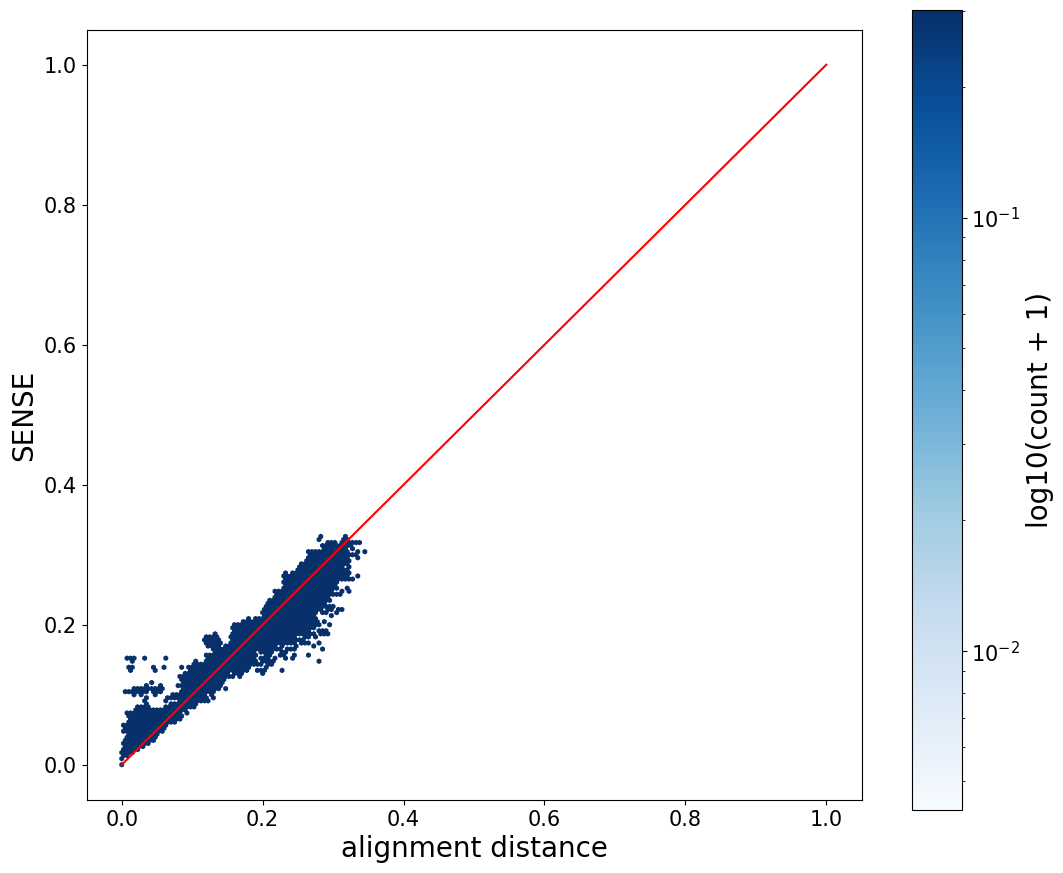

In [12]:
# evaluation
NUM_EVAL_N = 500 # number of eval pairs is N*(N-1)/2
pair_dist('./demo/eval.fa', NUM_EVAL_N, './demo/embeddings.txt', './demo/embeddings_dist.txt')
nw_df = pd.read_csv('./demo/eval_dist.txt', sep='\t', header=None)
my_df = pd.read_csv('./demo/embeddings_dist.txt', sep='\t', header=None)
my_plot(nw_df, my_df, save_fp='./demo/demo.png')